In [44]:
from keras.models import Sequential
"""Import from keras_preprocessing not from keras.preprocessing, because Keras may or maynot contain the features discussed here depending upon when you read this article, until the keras_preprocessed library is updated in Keras use the github version."""
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
#from tensorflow.keras import optimizers #., optimizers
import pandas as pd
import numpy as np

import tensorflow as tf


#Importing all the relevant library
%matplotlib inline
import h5py, os
#from functions import transforms as T
#from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
#from functions import transforms as T 
#from functions.subsample import MaskFunc
from PIL import Image

In [45]:
def load_data_path(train_data_path, val_data_path, test_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_val_test = ['train', 'val', 'test']
    data_path = [train_data_path, val_data_path, test_data_path]
      
    for i in range(len(data_path)):

        data_list[train_val_test[i]] = []
        
        which_data_path = data_path[i]
        t1 = 0
        t2 = 0
        t2dot = 0
        tr = 0
        te = 0
        alfa = 0
        for fname in sorted(os.listdir(which_data_path + '/images')):
            if fname != ".DS_Store":

            
                subject_data_path = os.path.join(which_data_path + '/images', fname)
                     
                if not os.path.isfile(subject_data_path): continue 
            
          #  im_frame = Image.open(subject_data_path)

            #get information from text file
            # this will return a tuple of root and extension
                split_tup = os.path.splitext(fname)

  
            # extract the file name and extension
                file_name = split_tup[0]
                file_path = os.path.join(which_data_path + '/texts', file_name) + '.txt'
                f = open(os.path.join(which_data_path + '/texts', file_name) + '.txt', 'r')
                line = f.readlines()[1]
            
                fields = line.split(',')
                t1 = float(fields[0])
                t2 = float(fields[1])
                t2dot = float(fields[2])
                tr = int(fields[3])
                te = int(fields[4])
                alfa = int(fields[5])
                f.close()
                
            # the first 5 slices are mostly noise so it is better to exlude them
                data_list[train_val_test[i]] += [(fname, t2dot)]
    
    return data_list

In [46]:
data_list = load_data_path ("data/train", "data/val", "data/test")

In [47]:
train_data = data_list['train']
val_data = data_list['val']
test_data = data_list['val']

In [48]:
train_df = pd.DataFrame(train_data, columns=['fnames', 'labels'])
train_df['labels']= train_df['labels'].astype(float)
train_df['labels'] = round(train_df['labels'], 3)
train_df['labels']= train_df['labels'].astype(str)
train_df['fnames']= train_df['fnames'].astype(str)
val_df = pd.DataFrame(val_data, columns=['fnames', 'labels'])
val_df['labels']= val_df['labels'].astype(float)
val_df['labels'] = round(val_df['labels'], 3)
val_df['labels']= val_df['labels'].astype(str)
val_df['fnames']= val_df['fnames'].astype(str)
test_df = pd.DataFrame(test_data, columns=['fnames', 'labels'])
test_df['labels']= test_df['labels'].astype(float)
test_df['labels'] = round(test_df['labels'], 3)
test_df['labels']= test_df['labels'].astype(str)
test_df['fnames']= test_df['fnames'].astype(str)
labels = train_df.labels.unique()

In [49]:
num_class = len(labels)
num_class

91

In [50]:
labels

array(['1.99', '0.062', '0.0', '-0.081', '-0.543', '-0.123', '-0.088',
       '-0.314', '0.088', '-0.094', '-0.087', '-0.089', '-0.114',
       '-0.113', '-0.115', '-0.122', '-0.091', '-0.116', '-0.112',
       '-0.093', '-0.148', '-0.09', '-0.084', '-0.107', '-0.151',
       '-0.136', '-0.105', '-0.095', '-0.127', '-0.145', '-0.097',
       '-0.11', '-0.108', '-0.119', '-0.149', '-0.141', '-0.131',
       '-0.137', '-0.147', '-0.143', '-0.12', '-0.374', '-0.117',
       '-0.128', '-0.152', '-0.13', '-0.146', '-0.54', '-0.15', '-0.134',
       '-0.124', '-0.083', '-0.109', '-0.135', '-0.153', '-0.129',
       '-0.14', '-0.138', '-0.133', '-0.086', '-0.132', '-0.106',
       '-0.125', '-0.102', '-0.103', '-0.144', '-0.092', '-0.085',
       '-0.359', '-0.139', '-0.111', '-0.101', '-0.096', '-0.126',
       '-0.099', '-0.46', '-0.082', '-0.142', '-0.571', '-0.098',
       '-0.104', '-0.121', '-0.118', '-0.573', '-0.1', '-0.325', '-0.529',
       '-0.315', '-0.494', '-0.566', '-0.395'], d

In [51]:
train_df.describe

<bound method NDFrame.describe of         fnames  labels
0        1.png    1.99
1       10.png    1.99
2      100.png    1.99
3     1000.png    1.99
4     1001.png   0.062
...        ...     ...
3704   995.png    1.99
3705   996.png     0.0
3706   997.png    1.99
3707   998.png  -0.395
3708   999.png    1.99

[3709 rows x 2 columns]>

In [52]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
      dataframe=train_df,
      directory="./data/train/images/",
      x_col="fnames",
      y_col="labels",
      batch_size=64,
      seed=42,
      shuffle=True,
      class_mode="categorical",
      target_size=(224,224))



valid_generator=test_datagen.flow_from_dataframe(
      dataframe=val_df,
      directory="./data/val/images/",
      x_col="fnames",
      y_col="labels",
      batch_size=64,
      seed=42,
      shuffle=True,
      class_mode="categorical",
     target_size=(224,224))


Found 3709 validated image filenames belonging to 91 classes.
Found 749 validated image filenames belonging to 63 classes.


In [53]:
train_generator.class_indices

{'-0.081': 0,
 '-0.082': 1,
 '-0.083': 2,
 '-0.084': 3,
 '-0.085': 4,
 '-0.086': 5,
 '-0.087': 6,
 '-0.088': 7,
 '-0.089': 8,
 '-0.09': 9,
 '-0.091': 10,
 '-0.092': 11,
 '-0.093': 12,
 '-0.094': 13,
 '-0.095': 14,
 '-0.096': 15,
 '-0.097': 16,
 '-0.098': 17,
 '-0.099': 18,
 '-0.1': 19,
 '-0.101': 20,
 '-0.102': 21,
 '-0.103': 22,
 '-0.104': 23,
 '-0.105': 24,
 '-0.106': 25,
 '-0.107': 26,
 '-0.108': 27,
 '-0.109': 28,
 '-0.11': 29,
 '-0.111': 30,
 '-0.112': 31,
 '-0.113': 32,
 '-0.114': 33,
 '-0.115': 34,
 '-0.116': 35,
 '-0.117': 36,
 '-0.118': 37,
 '-0.119': 38,
 '-0.12': 39,
 '-0.121': 40,
 '-0.122': 41,
 '-0.123': 42,
 '-0.124': 43,
 '-0.125': 44,
 '-0.126': 45,
 '-0.127': 46,
 '-0.128': 47,
 '-0.129': 48,
 '-0.13': 49,
 '-0.131': 50,
 '-0.132': 51,
 '-0.133': 52,
 '-0.134': 53,
 '-0.135': 54,
 '-0.136': 55,
 '-0.137': 56,
 '-0.138': 57,
 '-0.139': 58,
 '-0.14': 59,
 '-0.141': 60,
 '-0.142': 61,
 '-0.143': 62,
 '-0.144': 63,
 '-0.145': 64,
 '-0.146': 65,
 '-0.147': 66,
 '-0.148': 6

In [54]:
valid_generator.class_indices

{'-0.082': 0,
 '-0.084': 1,
 '-0.085': 2,
 '-0.086': 3,
 '-0.089': 4,
 '-0.091': 5,
 '-0.093': 6,
 '-0.094': 7,
 '-0.095': 8,
 '-0.096': 9,
 '-0.097': 10,
 '-0.099': 11,
 '-0.1': 12,
 '-0.101': 13,
 '-0.102': 14,
 '-0.104': 15,
 '-0.107': 16,
 '-0.108': 17,
 '-0.11': 18,
 '-0.111': 19,
 '-0.112': 20,
 '-0.113': 21,
 '-0.114': 22,
 '-0.116': 23,
 '-0.117': 24,
 '-0.118': 25,
 '-0.119': 26,
 '-0.12': 27,
 '-0.122': 28,
 '-0.123': 29,
 '-0.124': 30,
 '-0.125': 31,
 '-0.126': 32,
 '-0.127': 33,
 '-0.128': 34,
 '-0.129': 35,
 '-0.13': 36,
 '-0.131': 37,
 '-0.132': 38,
 '-0.134': 39,
 '-0.136': 40,
 '-0.137': 41,
 '-0.138': 42,
 '-0.139': 43,
 '-0.14': 44,
 '-0.141': 45,
 '-0.143': 46,
 '-0.144': 47,
 '-0.145': 48,
 '-0.146': 49,
 '-0.147': 50,
 '-0.148': 51,
 '-0.15': 52,
 '-0.151': 53,
 '-0.152': 54,
 '-0.466': 55,
 '-0.488': 56,
 '-0.502': 57,
 '-0.526': 58,
 '0.0': 59,
 '0.062': 60,
 '0.088': 61,
 '1.99': 62}

In [55]:
classes = train_generator.class_indices.copy()
classes.update(valid_generator.class_indices)
#classes = {**valid_generator.class_indices, ** train_generator.class_indices}
index = 0
for key, value in classes.items():
    classes[key] = index
    index += 1
classes

{'-0.081': 0,
 '-0.082': 1,
 '-0.083': 2,
 '-0.084': 3,
 '-0.085': 4,
 '-0.086': 5,
 '-0.087': 6,
 '-0.088': 7,
 '-0.089': 8,
 '-0.09': 9,
 '-0.091': 10,
 '-0.092': 11,
 '-0.093': 12,
 '-0.094': 13,
 '-0.095': 14,
 '-0.096': 15,
 '-0.097': 16,
 '-0.098': 17,
 '-0.099': 18,
 '-0.1': 19,
 '-0.101': 20,
 '-0.102': 21,
 '-0.103': 22,
 '-0.104': 23,
 '-0.105': 24,
 '-0.106': 25,
 '-0.107': 26,
 '-0.108': 27,
 '-0.109': 28,
 '-0.11': 29,
 '-0.111': 30,
 '-0.112': 31,
 '-0.113': 32,
 '-0.114': 33,
 '-0.115': 34,
 '-0.116': 35,
 '-0.117': 36,
 '-0.118': 37,
 '-0.119': 38,
 '-0.12': 39,
 '-0.121': 40,
 '-0.122': 41,
 '-0.123': 42,
 '-0.124': 43,
 '-0.125': 44,
 '-0.126': 45,
 '-0.127': 46,
 '-0.128': 47,
 '-0.129': 48,
 '-0.13': 49,
 '-0.131': 50,
 '-0.132': 51,
 '-0.133': 52,
 '-0.134': 53,
 '-0.135': 54,
 '-0.136': 55,
 '-0.137': 56,
 '-0.138': 57,
 '-0.139': 58,
 '-0.14': 59,
 '-0.141': 60,
 '-0.142': 61,
 '-0.143': 62,
 '-0.144': 63,
 '-0.145': 64,
 '-0.146': 65,
 '-0.147': 66,
 '-0.148': 6

In [56]:
num_class = len(classes)
num_class

95

In [57]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
      dataframe=train_df,
      directory="./data/train/images/",
      x_col="fnames",
      y_col="labels",
      batch_size=64,
      seed=42,
      shuffle=True,
      class_mode="categorical",
      classes= classes,
      target_size=(224,224))



valid_generator=test_datagen.flow_from_dataframe(
      dataframe=val_df,
      directory="./data/val/images/",
      x_col="fnames",
      y_col="labels",
      batch_size=64,
      seed=42,
      shuffle=True,
      class_mode="categorical",
     classes= classes,
     target_size=(224,224))

Found 3709 validated image filenames belonging to 95 classes.
Found 749 validated image filenames belonging to 95 classes.


In [58]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
      directory="./data/test/images",
      x_col="fnames",
      batch_size=1,
      seed=42,
      shuffle=False,
      class_mode=None,
      target_size=(224,224))

Found 749 validated image filenames.


In [59]:
from keras.optimizers import SGD

In [60]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_class, activation='sigmoid'))

#opt = SGD(lr=0.001, momentum=0.9)
opt =tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(optimizer=opt,loss="binary_crossentropy",metrics=["accuracy"])

In [61]:
n_epochs = 8 #100 #10

In [62]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=n_epochs
)

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
57/57 [==============================] - 828s 14s/step - loss: 0.2065 - accuracy: 0.4457 - val_loss: 0.0148 - val_accuracy: 0.8466
Epoch 2/8
57/57 [==============================] - 859s 15s/step - loss: 0.0198 - accuracy: 0.8360 - val_loss: 0.0103 - val_accuracy: 0.8807
Epoch 3/8
57/57 [==============================] - 832s 15s/step - loss: 0.0136 - accuracy: 0.8685 - val_loss: 0.0089 - val_accuracy: 0.8835
Epoch 4/8
57/57 [==============================] - 681s 12s/step - loss: 0.0106 - accuracy: 0.8655 - val_loss: 0.0078 - val_accuracy: 0.8778
Epoch 5/8
57/57 [==============================] - 670s 12s/step - loss: 0.0087 - accuracy: 0.8680 - val_loss: 0.0072 - val_accuracy: 0.8864
Epoch 6/8
57/57 [==============================] - 746s 13s/step - loss: 0.0076 - accuracy: 0.8753 - val_loss: 0.0071 - val_accuracy: 0.8807
Epoch 7/8
57/57 [==============================] - 725s 13s/step - loss: 0.0075 - accuracy: 0.8731 - val_loss: 0.0073 - val_accuracy: 0.8807
Epoch 8/8
57/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


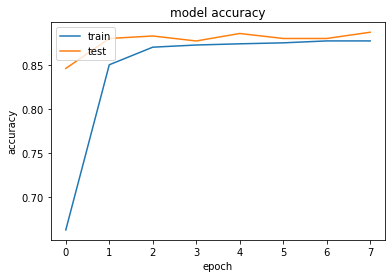

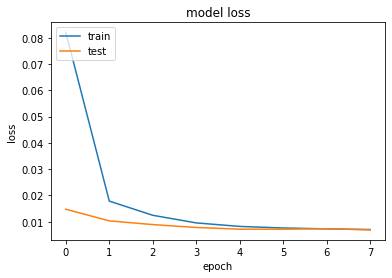

In [77]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


749/749 [==============================] - 66s 87ms/step


In [98]:
pred

array([[1.35479808e-10, 5.26551913e-09, 1.81937110e-09, ...,
        5.54137569e-10, 6.03112404e-09, 1.00000000e+00],
       [3.25811101e-13, 2.94069456e-11, 1.01467125e-11, ...,
        3.46230301e-11, 2.23226090e-11, 1.00000000e+00],
       [9.63877511e-09, 1.51252067e-07, 1.01021058e-07, ...,
        9.91281865e-08, 5.25281223e-08, 9.99999523e-01],
       ...,
       [6.98009133e-03, 1.17859244e-02, 6.05478883e-03, ...,
        5.02824783e-04, 1.73807144e-04, 3.95043935e-06],
       [5.23570727e-12, 5.28433075e-10, 1.82525467e-10, ...,
        2.39080089e-10, 1.17863319e-09, 1.00000000e+00],
       [9.00044372e-10, 2.32330475e-08, 1.48386077e-08, ...,
        1.84939459e-08, 5.29453281e-09, 1.00000000e+00]], dtype=float32)

In [99]:
pred_bool = (pred >0.5)

In [100]:
predictions=[]
labels = train_generator.class_indices

textfile = open("T2dot_labels.txt", "w")
for element in labels:
    textfile.write(element + "\n")
textfile.close()
labels = dict((v,k) for k,v in labels.items())
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(",".join(l))
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("T2dotresults.csv",index=False)

In [101]:
results

,Filename,Predictions
0,1.png,1.99
1,10.png,1.99
2,100.png,1.99
3,101.png,1.99
4,102.png,1.99
...,...,...
744,95.png,0.0
745,96.png,1.99
746,97.png,
747,98.png,1.99


In [84]:
import PIL
original = PIL.Image.open("data/test/images/100.png")
file_type = original.format

original.save("testing/test.png", format="png")


In [85]:
import PIL
original = PIL.Image.open("data/test/images/100.png") # replace later with image input
file_type = original.format

original.save("testing/test.png", format="png")
##########################
testdata = []
for fname in sorted(os.listdir('testing')):
    if fname == ".DS_Store": continue
            
    subject_data_path = os.path.join('testing', fname)                   
    if not os.path.isfile(subject_data_path): continue          
    testdata.append(fname)
    
df = pd.DataFrame(testdata, columns=['fnames'])
df['fnames']= df['fnames'].astype(str)
test_datagen = ImageDataGenerator(rescale=1./255.)
test_g=test_datagen.flow_from_dataframe(
     dataframe= df,
      directory="./testing",
      x_col="fnames",
      batch_size=1,
      seed=42,
      shuffle=False,
      class_mode=None,
      target_size=(224,224))
STEP_SIZE_TEST=test_g.n//test_g.batch_size
pred = model.predict_generator(test_g,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_bool = (pred >0.5)
predictions=[]
#labels = train_generator.class_indices
#labels = dict((v,k) for k,v in labels.items())
labels = {}
file1 = open('T2dot_labels.txt', 'r')
Lines = file1.readlines()
 
count = 0
# Strips the newline character
for line in Lines:
    labels[count] = line.strip()
    count += 1
    
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(",".join(l))
    
    
if predictions[0] == '':
    result = 0
else:
    result = float (predictions[0] )
#result = float (predictions[0] ) 

Found 1 validated image filenames.
1/1 [==============================] - 0s 135ms/step


In [86]:
predictions[0]

'1.99'

In [87]:
result

1.99

In [88]:
labels

{0: '-0.081',
 1: '-0.082',
 2: '-0.083',
 3: '-0.084',
 4: '-0.085',
 5: '-0.086',
 6: '-0.087',
 7: '-0.088',
 8: '-0.089',
 9: '-0.09',
 10: '-0.091',
 11: '-0.092',
 12: '-0.093',
 13: '-0.094',
 14: '-0.095',
 15: '-0.096',
 16: '-0.097',
 17: '-0.098',
 18: '-0.099',
 19: '-0.1',
 20: '-0.101',
 21: '-0.102',
 22: '-0.103',
 23: '-0.104',
 24: '-0.105',
 25: '-0.106',
 26: '-0.107',
 27: '-0.108',
 28: '-0.109',
 29: '-0.11',
 30: '-0.111',
 31: '-0.112',
 32: '-0.113',
 33: '-0.114',
 34: '-0.115',
 35: '-0.116',
 36: '-0.117',
 37: '-0.118',
 38: '-0.119',
 39: '-0.12',
 40: '-0.121',
 41: '-0.122',
 42: '-0.123',
 43: '-0.124',
 44: '-0.125',
 45: '-0.126',
 46: '-0.127',
 47: '-0.128',
 48: '-0.129',
 49: '-0.13',
 50: '-0.131',
 51: '-0.132',
 52: '-0.133',
 53: '-0.134',
 54: '-0.135',
 55: '-0.136',
 56: '-0.137',
 57: '-0.138',
 58: '-0.139',
 59: '-0.14',
 60: '-0.141',
 61: '-0.142',
 62: '-0.143',
 63: '-0.144',
 64: '-0.145',
 65: '-0.146',
 66: '-0.147',
 67: '-0.148

In [89]:
model

In [90]:
# save the model
filename2 = 'model_t2dot.h5' 
model.save(filename2)

In [91]:
from keras.models import load_model
# load model
model = load_model('model_t2dot.h5')

In [ ]:
y_test = test_df['labels'].astype(str)
y_test

In [92]:
y_test = test_df['labels'].astype(str)
test_datagen = ImageDataGenerator(rescale=1./255.)
test_g=test_datagen.flow_from_dataframe(
     dataframe= test_df,
      directory="./data/test/images",
      x_col="fnames",
      batch_size=1,
      seed=42,
      shuffle=False,
      class_mode=None,
      target_size=(224,224)) # to avoid loss of information
STEP_SIZE_TEST=test_g.n//test_g.batch_size
pred = model.predict_generator(test_g,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_bool = (pred >0.5)
predictions=[]
#labels = train_generator.class_indices
#labels = dict((v,k) for k,v in labels.items())
labels = {}
file1 = open('T2dot_labels.txt', 'r')
Lines = file1.readlines()
 
count = 0
# Strips the newline character
for line in Lines:
    labels[count] = line.strip()
    count += 1
    
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
      
    predictions.append(",".join(l))
y_pred =[]
for i in range(0, len(predictions)):
    if predictions[i] == '':
        y_pred.append(0)
    else:
        listValue  = list(map(float, predictions[i].split(',')))

        y_pred.append(str(round(max(listValue), 2)))

Found 749 validated image filenames.
749/749 [==============================] - 91s 115ms/step


In [93]:
len(y_pred)

749

In [94]:

# Importing all necessary libraries
from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: {accuracy_score(y_test, y_pred)}")

Accuracy of the classifier is: 0.6475300400534045


In [95]:
from sklearn.metrics import confusion_matrix

# confusion_matrix funnction a matrix containing the summary of predictions
print(confusion_matrix(y_test, y_pred))

[[  0   0   0 ...   0   0   1]
 [  0   0   0 ...   0   0   2]
 [  0   0   0 ...   0   0   1]
 ...
 [  0   0   0 ...   0   0  12]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0  11 483]]


In [96]:

from sklearn.metrics import mean_squared_error
  # Calculation of Mean Squared Error (MSE)
mean_squared_error([float(i) for i in y_test], [float(i) for i in y_pred])

1.2916114579439253